In [2]:
import h5py
import numpy as np
import pandas as pd
import subprocess
import os
import matplotlib.pyplot as plt

from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

In [237]:
mmseqs_res = pd.read_csv("../data/results.tsv", sep='\t')
mmseqs_res

,query,target,fident,evalue,bits
0,S0F1M9,S0F1M9,1.000,5.672000e-49,162
1,S0F1M9,S0F1P1,0.939,2.678000e-44,148
2,S0F1M9,P0DMQ4,0.824,9.828000e-37,126
3,S0F1M9,P82228,1.000,1.009000e-21,83
4,S0F1M9,S0F1M6,0.532,6.265000e-20,78
...,...,...,...,...,...
26842717,P0C2P4,P84745,1.000,1.439000e+05,7
26842718,P0C2P4,P0CJ34,1.000,1.439000e+05,7
26842719,P0C2P4,P0DM54,1.000,1.439000e+05,7
26842720,P0C2P4,P0DKZ9,0.610,1.966000e+05,7


In [238]:
ids = []

for record in SeqIO.parse("../data/toxins.fasta", "fasta"):
    fasta_id = record.id
    ids.append(fasta_id)

matrix = np.empty((5181, 5181))
matrix[:] = np.nan
evalue_matrix = pd.DataFrame(matrix, index=ids, columns=ids)
evalue_matrix.iloc[:5, :5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,NaN,NaN,NaN,NaN,NaN
Q5Y4U7,NaN,NaN,NaN,NaN,NaN
Q5Y4U2,NaN,NaN,NaN,NaN,NaN
A0A1P8NVS2,NaN,NaN,NaN,NaN,NaN
P83911,NaN,NaN,NaN,NaN,NaN


In [239]:
for _, row in mmseqs_res.iterrows():
    query_index = row['query']
    subject_index = row['target']
    evalue = row['evalue']
    
    # Update the DataFrame 
    evalue_matrix.at[query_index, subject_index] = evalue
evalue_matrix.iloc[:5, :5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,5.672000e-49,4.093000e+02,1.623000e+02,8.421000e+03,4.093000e+02
Q5Y4U7,2.015000e+02,2.068000e-47,9.857000e-02,7.892000e+03,4.878000e-01
Q5Y4U2,5.617000e+02,5.327000e-02,1.704000e-84,7.688000e+03,1.741000e+02
A0A1P8NVS2,5.138000e+03,6.966000e+03,2.787000e+03,1.885000e-39,1.727000e+04
P83911,2.889000e+01,1.485000e-01,1.066000e+01,1.544000e+04,7.489000e-30


In [241]:
np.nanmin(evalue_matrix[(evalue_matrix != 0) & (~np.isnan(evalue_matrix))])

5e-324

In [242]:
nan_replacement = 1
zero_replacement = np.nanmin(evalue_matrix[(evalue_matrix != 0) & (~np.isnan(evalue_matrix))])

In [243]:
replaced_matrix = np.where(np.isnan(matrix), nan_replacement, matrix)
replaced_matrix = np.where(replaced_matrix == 0, zero_replacement, replaced_matrix)
replaced_matrix[:5,:5]

array([[5.672e-49, 4.093e+02, 1.623e+02, 8.421e+03, 4.093e+02],
       [2.015e+02, 2.068e-47, 9.857e-02, 7.892e+03, 4.878e-01],
       [5.617e+02, 5.327e-02, 1.704e-84, 7.688e+03, 1.741e+02],
       [5.138e+03, 6.966e+03, 2.787e+03, 1.885e-39, 1.727e+04],
       [2.889e+01, 1.485e-01, 1.066e+01, 1.544e+04, 7.489e-30]])

### Matrix symmetrization

In [244]:
symmetric_matrix = (replaced_matrix + replaced_matrix.T) / 2
symmetric_matrix[:5,:5]

array([[5.67200e-49, 3.05400e+02, 3.62000e+02, 6.77950e+03, 2.19095e+02],
       [3.05400e+02, 2.06800e-47, 7.59200e-02, 7.42900e+03, 3.18150e-01],
       [3.62000e+02, 7.59200e-02, 1.70400e-84, 5.23750e+03, 9.23800e+01],
       [6.77950e+03, 7.42900e+03, 5.23750e+03, 1.88500e-39, 1.63550e+04],
       [2.19095e+02, 3.18150e-01, 9.23800e+01, 1.63550e+04, 7.48900e-30]])

### -log 

In [245]:
log_matrix = -np.log(symmetric_matrix)
log_matrix[:5,:5]

array([[111.09112777,  -5.72162239,  -5.89164421,  -8.82165863,
         -5.38950543],
       [ -5.72162239, 107.49491741,   2.57807512,  -8.91314654,
          1.14523231],
       [ -5.89164421,   2.57807512, 192.88416938,  -8.56359956,
         -4.52591051],
       [ -8.82165863,  -8.91314654,  -8.56359956,  89.16689081,
         -9.70228894],
       [ -5.38950543,   1.14523231,  -4.52591051,  -9.70228894,
         67.06411751]])

### Normalize between 0 and 1

In [246]:
scaled_matrix = (log_matrix - np.min(log_matrix)) / (np.max(log_matrix) - np.min(log_matrix))
scaled_matrix[:5,:5]

array([[0.16468575, 0.01062319, 0.01039895, 0.0065346 , 0.01106122],
       [0.01062319, 0.15994276, 0.02156954, 0.00641394, 0.01967978],
       [0.01039895, 0.02156954, 0.27256134, 0.00687495, 0.0122002 ],
       [0.0065346 , 0.00641394, 0.00687495, 0.13577021, 0.00537315],
       [0.01106122, 0.01967978, 0.0122002 , 0.00537315, 0.10661919]])

### 1 - Matrix
because we applied the negative log before and want to keep the interpretation of 
small value -> high similiarity
high value -> low similarity

In [247]:
matrix = 1 - scaled_matrix
matrix[:5,:5]

array([[0.83531425, 0.98937681, 0.98960105, 0.9934654 , 0.98893878],
       [0.98937681, 0.84005724, 0.97843046, 0.99358606, 0.98032022],
       [0.98960105, 0.97843046, 0.72743866, 0.99312505, 0.9877998 ],
       [0.9934654 , 0.99358606, 0.99312505, 0.86422979, 0.99462685],
       [0.98893878, 0.98032022, 0.9877998 , 0.99462685, 0.89338081]])

In [248]:
evalue_matrix.loc[:, :] = matrix
evalue_matrix.iloc[:5,:5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,0.835314,0.989377,0.989601,0.993465,0.988939
Q5Y4U7,0.989377,0.840057,0.978430,0.993586,0.980320
Q5Y4U2,0.989601,0.978430,0.727439,0.993125,0.987800
A0A1P8NVS2,0.993465,0.993586,0.993125,0.864230,0.994627
P83911,0.988939,0.980320,0.987800,0.994627,0.893381


In [249]:
clustering = HDBSCAN(min_samples=25, metric='precomputed').fit(matrix)
labels = clustering.labels_
len(set(labels))

38

In [287]:
clustersss = pd.DataFrame(labels, columns=['mmseqs2_label'])
clustersss['Entry'] = evalue_matrix.index
clustersss

,mmseqs2_label,Entry
0,20,S0F1M9
1,28,Q5Y4U7
2,-1,Q5Y4U2
3,32,A0A1P8NVS2
4,-1,P83911
...,...,...
5176,32,P24160
5177,32,G1AS76
5178,32,Q9BPC8
5179,32,A0A3G3C7V6


In [288]:
clustersss['mmseqs2_label'].value_counts()

mmseqs2_label
-1     1979
 18     479
 27     334
 12     270
 11     206
 33     194
 9      145
 10     143
 23     106
 14     100
 24      92
 25      92
 8       84
 15      82
 29      61
 32      60
 5       55
 30      53
 19      51
 31      51
 28      49
 35      44
 1       43
 6       41
 34      38
 17      38
 36      36
 3       34
 20      32
 13      31
 26      29
 7       26
 2       26
 16      25
 22      16
 4       13
 21      12
 0       11
Name: count, dtype: int64

## read in BLAST results and make matrix

In [27]:
blast_res = pd.read_csv("/Users/selinturkoglu/PycharmProjects/pa/BLAST/blast_res.txt", sep='\t', header=None, usecols=[0, 1, 3, 10], names=['query', 'subject', 'pident', 'e-value'])

blast_res.iloc[:5, :5]

,query,subject,pident,e-value
0,S0F1M9,S0F1M9,74,2.520000e-51
1,S0F1M9,S0F1P1,74,1.160000e-37
2,S0F1M9,P0DMQ4,73,4.380000e-30
3,S0F1M9,S0F1M6,75,4.450000e-23
4,S0F1M9,S0F207,75,4.450000e-23


In [28]:
ids = []

for record in SeqIO.parse("/Users/selinturkoglu/PycharmProjects/pa/data/toxins.fasta", "fasta"):
    fasta_id = record.id
    ids.append(fasta_id)

matrix = np.empty((5181, 5181))
matrix[:] = np.nan
evalue_matrix = pd.DataFrame(matrix, index=ids, columns=ids)
evalue_matrix.iloc[:5, :5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,NaN,NaN,NaN,NaN,NaN
Q5Y4U7,NaN,NaN,NaN,NaN,NaN
Q5Y4U2,NaN,NaN,NaN,NaN,NaN
A0A1P8NVS2,NaN,NaN,NaN,NaN,NaN
P83911,NaN,NaN,NaN,NaN,NaN


### fill in e-value matrix from blast data

In [29]:
for _, row in blast_res.iterrows():
    query_index = row['query'] 
    subject_index = row['subject'] 
    evalue = row['e-value']
    
    # Update the DataFrame
    evalue_matrix.at[query_index, subject_index] = evalue
evalue_matrix.iloc[:5, :5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,2.520000e-51,NaN,NaN,NaN,NaN
Q5Y4U7,NaN,4.270000e-49,2.300000e+00,NaN,NaN
Q5Y4U2,NaN,3.800000e+00,2.440000e-83,NaN,NaN
A0A1P8NVS2,NaN,NaN,NaN,1.540000e-42,NaN
P83911,NaN,NaN,NaN,NaN,1.820000e-26


### Matrix

In [30]:
matrix = evalue_matrix.to_numpy()
matrix[:5,:5]

array([[2.52e-51,      nan,      nan,      nan,      nan],
       [     nan, 4.27e-49, 2.30e+00,      nan,      nan],
       [     nan, 3.80e+00, 2.44e-83,      nan,      nan],
       [     nan,      nan,      nan, 1.54e-42,      nan],
       [     nan,      nan,      nan,      nan, 1.82e-26]])

### replacing NaN and 0 while keeping biological accuracy
low e-value indicates a high probability for a high similarity
high e-value indicates the opposite

replacing 0s with 1e-100 for log 0 handling
replacing NaN with 1

In [31]:
np.nanmin(matrix[(matrix != 0) & (~np.isnan(matrix))])

1.02e-180

In [32]:
nan_replacement = 1
zero_replacement = 1.02e-180

In [33]:
replaced_matrix = np.where(np.isnan(matrix), nan_replacement, matrix)
replaced_matrix = np.where(replaced_matrix == 0, zero_replacement, replaced_matrix)
replaced_matrix[:5,:5]

array([[2.52e-51, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 4.27e-49, 2.30e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 3.80e+00, 2.44e-83, 1.00e+00, 1.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 1.54e-42, 1.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.82e-26]])

### Matrix symmetrization

In [34]:
symmetric_matrix = (replaced_matrix + replaced_matrix.T) / 2
symmetric_matrix[:5,:5]

array([[2.52e-51, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 4.27e-49, 3.05e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 3.05e+00, 2.44e-83, 1.00e+00, 1.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 1.54e-42, 1.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.82e-26]])

### -log 

In [35]:
log_matrix = -np.log(symmetric_matrix)
log_matrix[:5,:5]

array([[116.50758084,  -0.        ,  -0.        ,  -0.        ,
         -0.        ],
       [ -0.        , 111.37505573,  -1.11514159,  -0.        ,
         -0.        ],
       [ -0.        ,  -1.11514159, 190.22256468,  -0.        ,
         -0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  96.27679149,
         -0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         59.26837592]])

### Normalize between 0 and 1

In [36]:
scaled_matrix = (log_matrix - np.min(log_matrix)) / (np.max(log_matrix) - np.min(log_matrix))
scaled_matrix[:5,:5]

array([[0.28508868, 0.00552512, 0.00552512, 0.00552512, 0.00552512],
       [0.00552512, 0.27277303, 0.00284931, 0.00552512, 0.00552512],
       [0.00552512, 0.00284931, 0.46197007, 0.00552512, 0.00552512],
       [0.00552512, 0.00552512, 0.00552512, 0.23654427, 0.00552512],
       [0.00552512, 0.00552512, 0.00552512, 0.00552512, 0.14774143]])

### 1 - Matrix
because we applied the negative log before and want to keep the interpretation of 
small value -> high similiarity
high value -> low similarity

In [37]:
matrix = 1 - scaled_matrix
matrix[:5,:5]

array([[0.71491132, 0.99447488, 0.99447488, 0.99447488, 0.99447488],
       [0.99447488, 0.72722697, 0.99715069, 0.99447488, 0.99447488],
       [0.99447488, 0.99715069, 0.53802993, 0.99447488, 0.99447488],
       [0.99447488, 0.99447488, 0.99447488, 0.76345573, 0.99447488],
       [0.99447488, 0.99447488, 0.99447488, 0.99447488, 0.85225857]])

In [152]:
evalue_matrix.loc[:, :] = matrix
evalue_matrix.iloc[:5,:5]

,S0F1M9,Q5Y4U7,Q5Y4U2,A0A1P8NVS2,P83911
S0F1M9,0.714911,0.994475,0.994475,0.994475,0.994475
Q5Y4U7,0.994475,0.727227,0.997151,0.994475,0.994475
Q5Y4U2,0.994475,0.997151,0.538030,0.994475,0.994475
A0A1P8NVS2,0.994475,0.994475,0.994475,0.763456,0.994475
P83911,0.994475,0.994475,0.994475,0.994475,0.852259


In [153]:
clustering = HDBSCAN(min_samples=50, metric='precomputed').fit(evalue_matrix)
labels = clustering.labels_
len(set(labels))

36

In [154]:
blast_clustering = pd.DataFrame(labels, columns=['blast_labels'])
blast_clustering['Entry'] = evalue_matrix.index
blast_clustering

,blast_labels,Entry
0,-1,S0F1M9
1,-1,Q5Y4U7
2,-1,Q5Y4U2
3,-1,A0A1P8NVS2
4,-1,P83911
...,...,...
5176,34,P24160
5177,34,G1AS76
5178,34,Q9BPC8
5179,34,A0A3G3C7V6


In [155]:
blast_clustering['blast_labels'].value_counts()

blast_labels
 0     1077
-1      748
 18     476
 23     328
 16     270
 4      266
 21     207
 32     205
 33     190
 15     145
 19     143
 27     118
 20     117
 3      103
 26      89
 30      88
 25      88
 31      86
 24      82
 22      72
 7       63
 29      60
 34      25
 2       21
 9       21
 6       21
 1       10
 5       10
 8       10
 28       9
 10       7
 14       6
 17       5
 12       5
 11       5
 13       5
Name: count, dtype: int64

## Read in embeddings

In [4]:
path_embeds = 'data/mature_seqs_prot_t5_xl_uniref50.h5'
new_embeds = 'data/embed_noSP_prot_t5_xl_uniref50.h5'
embeds_nontox_all = '../data/nontox_all.h5'

def print_structure(name, obj):
    if isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
        
with h5py.File(embeds_nontox_all, 'r') as f:
    f.visititems(print_structure)

Dataset: sp|A0A023FDY8|EV974_AMBCJ, shape: (1024,), dtype: float16
Dataset: sp|A0A023FFD0|EV991_AMBCJ, shape: (1024,), dtype: float16
Dataset: sp|A0A024QYT3|OST2A_ONCMY, shape: (1024,), dtype: float16
Dataset: sp|A0A024RBG1|NUD4B_HUMAN, shape: (1024,), dtype: float16
Dataset: sp|A0A026W182|ORCO_OOCBI, shape: (1024,), dtype: float16
Dataset: sp|A0A044RE18|BLI_ONCVO, shape: (1024,), dtype: float16
Dataset: sp|A0A060WQA3|OTOL1_ONCMY, shape: (1024,), dtype: float16
Dataset: sp|A0A060X6Z0|TY3H_ONCMY, shape: (1024,), dtype: float16
Dataset: sp|A0A060XQP6|OMM64_ONCMY, shape: (1024,), dtype: float16
Dataset: sp|A0A061ACU2|PIEZ1_CAEEL, shape: (1024,), dtype: float16
Dataset: sp|A0A061AE05|PAPSH_CAEEL, shape: (1024,), dtype: float16
Dataset: sp|A0A061I403|FICD_CRIGR, shape: (1024,), dtype: float16
Dataset: sp|A0A075B6H7|KV37_HUMAN, shape: (1024,), dtype: float16
Dataset: sp|A0A075B6H8|KVD42_HUMAN, shape: (1024,), dtype: float16
Dataset: sp|A0A075B6H9|LV469_HUMAN, shape: (1024,), dtype: float16
D

In [5]:
with h5py.File(embeds_nontox_all, 'r') as h5_file:
    dfs = []
    
    for dataset in h5_file.keys():
        data = np.array(h5_file[dataset])  
        entry_name = dataset.split('|')[1]
        row = [entry_name] + data.tolist()
        dfs.append(row)
    
    columns = ['identifier'] + [f'{i}' for i in range(1024)]
    embeddings = pd.DataFrame(dfs, columns=columns)
#embeddings.set_index('Entry Name', inplace=True)
embeddings.head()

,identifier,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,A0A023FDY8,0.055756,0.018509,0.110962,0.020035,-0.055359,-0.015686,-0.044434,-0.150269,0.003416,...,-0.095520,-0.064270,0.009506,-0.104919,0.004574,-0.050354,0.001474,-0.038727,0.104858,0.012985
1,A0A023FFD0,0.020996,0.042725,0.129272,-0.020035,-0.052917,-0.022247,-0.032928,-0.133667,0.018112,...,-0.064514,-0.060883,0.019913,-0.101440,0.090637,-0.086914,-0.035431,-0.008286,0.112549,0.056763
2,A0A024QYT3,-0.011688,0.032654,0.138062,-0.013138,-0.003546,-0.093628,-0.023590,-0.115967,-0.039398,...,-0.090149,0.012611,0.002106,-0.074341,0.002439,0.011864,0.013969,0.024689,0.090088,0.037079
3,A0A024RBG1,0.057922,-0.003719,0.012596,0.005135,-0.004623,0.074890,-0.019867,-0.065735,0.016403,...,-0.070801,0.018082,0.045563,-0.037537,0.017456,0.011841,-0.017059,-0.056122,0.014297,-0.019943
4,A0A026W182,0.013809,0.009529,-0.008331,-0.010834,0.014641,0.028442,0.028198,-0.095154,-0.019806,...,-0.003447,-0.000072,-0.000091,-0.036591,0.043610,0.040741,0.002174,0.016006,0.039368,-0.002729


In [6]:
embeddings['combined'] = embeddings.loc[:, embeddings.columns != 'identifier'].apply(lambda row: row.tolist(), axis=1)
embeddings.head()

,identifier,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,combined
0,A0A023FDY8,0.055756,0.018509,0.110962,0.020035,-0.055359,-0.015686,-0.044434,-0.150269,0.003416,...,-0.064270,0.009506,-0.104919,0.004574,-0.050354,0.001474,-0.038727,0.104858,0.012985,"[0.055755615234375, 0.0185089111328125, 0.1109..."
1,A0A023FFD0,0.020996,0.042725,0.129272,-0.020035,-0.052917,-0.022247,-0.032928,-0.133667,0.018112,...,-0.060883,0.019913,-0.101440,0.090637,-0.086914,-0.035431,-0.008286,0.112549,0.056763,"[0.02099609375, 0.042724609375, 0.129272460937..."
2,A0A024QYT3,-0.011688,0.032654,0.138062,-0.013138,-0.003546,-0.093628,-0.023590,-0.115967,-0.039398,...,0.012611,0.002106,-0.074341,0.002439,0.011864,0.013969,0.024689,0.090088,0.037079,"[-0.011688232421875, 0.03265380859375, 0.13806..."
3,A0A024RBG1,0.057922,-0.003719,0.012596,0.005135,-0.004623,0.074890,-0.019867,-0.065735,0.016403,...,0.018082,0.045563,-0.037537,0.017456,0.011841,-0.017059,-0.056122,0.014297,-0.019943,"[0.05792236328125, -0.003719329833984375, 0.01..."
4,A0A026W182,0.013809,0.009529,-0.008331,-0.010834,0.014641,0.028442,0.028198,-0.095154,-0.019806,...,-0.000072,-0.000091,-0.036591,0.043610,0.040741,0.002174,0.016006,0.039368,-0.002729,"[0.0138092041015625, 0.00952911376953125, -0.0..."


In [10]:
nontox = pd.read_csv('../data/nontox_all_embeds.csv').drop(columns=['Unnamed: 0', 'combined'])
nontox

,identifier,Sequence
0,A0A023FDY8,ENTQQEEQDYDYGTDTCPFPVLANKTNKAKFVGCHQKCNGGDQKLT...
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...
2,A0A060XQP6,GTEADNDERAASLLVHLKGDKDGGGLTGSPDGVSAGTTDGTDSSKE...
3,A0A061ACU2,MTVPPLLKSCVVKLLLPAALLAAAIIRPSFLSIGYVLLALVSAVLP...
4,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...
...,...,...
21479,W6RTA4,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...
21480,X2JAU8,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...
21481,X2JDY8,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...
21482,X4Y2L4,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...


In [11]:
nontox = nontox.merge(embeddings[['identifier', 'combined']], on='identifier', how='left')
nontox

,identifier,Sequence,combined
0,A0A023FDY8,ENTQQEEQDYDYGTDTCPFPVLANKTNKAKFVGCHQKCNGGDQKLT...,"[0.055755615234375, 0.0185089111328125, 0.1109..."
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,"[0.0186614990234375, 0.0379638671875, 0.036102..."
2,A0A060XQP6,GTEADNDERAASLLVHLKGDKDGGGLTGSPDGVSAGTTDGTDSSKE...,"[0.10888671875, 0.012176513671875, 0.170166015..."
3,A0A061ACU2,MTVPPLLKSCVVKLLLPAALLAAAIIRPSFLSIGYVLLALVSAVLP...,"[0.036407470703125, -0.059844970703125, 0.0141..."
4,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,"[0.0618896484375, 0.0238494873046875, -0.02001..."
...,...,...,...
21479,W6RTA4,MSSWFSYFGFSKGPPLEEVREESEEDAQVPEQVVSKNTEEEIADAI...,"[0.1593017578125, 0.0726318359375, 0.033996582..."
21480,X2JAU8,MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...,"[0.0020542144775390625, -0.0240478515625, 0.04..."
21481,X2JDY8,MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...,"[0.0010547637939453125, -0.0033245086669921875..."
21482,X4Y2L4,MKEIAVTIDDKNVIASVSESFHGVAFDASLFSPKGLWSFVDITSPK...,"[0.036163330078125, -0.00980377197265625, 0.02..."


In [13]:
print(len(nontox['combined'][0]))

1024


In [14]:
nontox.to_csv('../data/nontox_all_embeds.csv')

In [355]:
embedding_array = embeddings.loc[:, ~embeddings.columns.isin(['identifier', 'combined'])]
X = np.array(embedding_array)
print(X.shape)
X[:5,:5]

(5181, 1024)


array([[ 0.03108823,  0.02535451, -0.01855685, -0.04165485, -0.04060773],
       [-0.00180903, -0.00429891,  0.16559291, -0.03282849, -0.03593037],
       [ 0.03654356,  0.01461845, -0.01783529, -0.05036539, -0.03614426],
       [ 0.02528037,  0.02896557, -0.01573249, -0.02825463, -0.03212481],
       [ 0.01846454,  0.01968968,  0.21743846, -0.03309237, -0.0588276 ]])

In [356]:
# pre calc for loss plotting
pca_full = PCA(n_components=1024)
pca_full.fit(X)
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

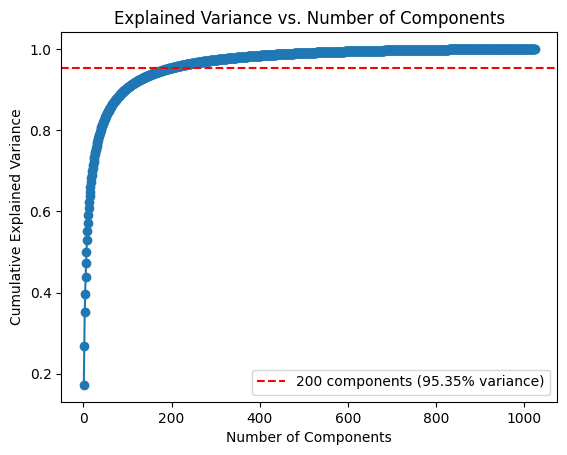

In [357]:
# plot loss
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=cumulative_variance[199], color='r', linestyle='--', label=f'200 components ({cumulative_variance[199]:.2%} variance)')
plt.legend()
plt.show()

In [358]:
# reduce to 200 components
pca = PCA(n_components=200)
reduced_data = pca.fit_transform(X)

In [359]:
embedding_clustering = HDBSCAN(min_cluster_size=25).fit(reduced_data)
embedding_labels = embedding_clustering.labels_
len(np.unique(embedding_labels))

26

In [360]:
embeddings['embed_label'] = embedding_labels
embeddings = embeddings[['Entry', 'combined', 'embed_label']]
embeddings

,Entry,combined,embed_label
0,A0A023VZM6,"[0.03108822926878929, 0.025354508310556412, -0...",-1
1,A0A023VZR2,"[-0.0018090278608724475, -0.004298912826925516...",-1
2,A0A023W082,"[0.03654356300830841, 0.014618448913097382, -0...",-1
3,A0A023W090,"[0.02528037317097187, 0.02896556630730629, -0....",-1
4,A0A023W0B6,"[0.01846454292535782, 0.01968967728316784, 0.2...",-1
...,...,...,...
5176,X5IGW1,"[0.05387260019779205, -0.035220950841903687, 0...",-1
5177,X5IWS1,"[0.024374239146709442, 0.027036283165216446, 0...",-1
5178,X5IWT5,"[0.06155085936188698, 0.031217582523822784, 0....",-1
5179,X5IXY8,"[0.026759454980492592, 0.09008943289518356, 0....",-1


In [361]:
pd.DataFrame(embedding_labels).value_counts()

0  
-1     2782
 3      481
 13     332
 1      275
 6      143
 11     134
 9      115
 5      113
 14     103
 8       65
 19      63
 18      62
 17      60
 20      54
 15      49
 21      38
 7       38
 24      35
 2       34
 23      34
 16      31
 22      31
 0       29
 12      29
 4       26
 10      25
Name: count, dtype: int64

In [362]:
noise = embeddings[embeddings['embed_label'] == -1]
noise

,Entry,combined,embed_label
0,A0A023VZM6,"[0.03108822926878929, 0.025354508310556412, -0...",-1
1,A0A023VZR2,"[-0.0018090278608724475, -0.004298912826925516...",-1
2,A0A023W082,"[0.03654356300830841, 0.014618448913097382, -0...",-1
3,A0A023W090,"[0.02528037317097187, 0.02896556630730629, -0....",-1
4,A0A023W0B6,"[0.01846454292535782, 0.01968967728316784, 0.2...",-1
...,...,...,...
5176,X5IGW1,"[0.05387260019779205, -0.035220950841903687, 0...",-1
5177,X5IWS1,"[0.024374239146709442, 0.027036283165216446, 0...",-1
5178,X5IWT5,"[0.06155085936188698, 0.031217582523822784, 0....",-1
5179,X5IXY8,"[0.026759454980492592, 0.09008943289518356, 0....",-1


In [363]:
noise_embeds = noise['combined'].apply(np.array).tolist()
noise_embeds = np.array(noise_embeds)
noise_embeds[:5,:5]

array([[ 0.03108823,  0.02535451, -0.01855685, -0.04165485, -0.04060773],
       [-0.00180903, -0.00429891,  0.16559291, -0.03282849, -0.03593037],
       [ 0.03654356,  0.01461845, -0.01783529, -0.05036539, -0.03614426],
       [ 0.02528037,  0.02896557, -0.01573249, -0.02825463, -0.03212481],
       [ 0.01846454,  0.01968968,  0.21743846, -0.03309237, -0.0588276 ]])

In [364]:
noise_embeds_clustering = HDBSCAN(min_cluster_size=20).fit(noise_embeds)
noise_embeds_labels = noise_embeds_clustering.labels_
len(np.unique(noise_embeds_labels))

8

In [365]:
noise_entries = noise['Entry'].values
noise_indices = embeddings[embeddings['Entry'].isin(noise_entries)].index

# Calculate the max label for non-noise embedding labels
max_embedding_label = len(np.unique(embedding_labels[embedding_labels != -1])) - 1  # Should be 24 if labels are 0–24

# Offset non-noise labels in noise_embeds_labels by max_embedding_label + 1 (i.e., 25)
updated_labels = np.where(noise_embeds_labels != -1, 
                          noise_embeds_labels + max_embedding_label + 1,  # Starts noise labels at 25
                          -1)

embeddings.loc[noise_indices, 'embed_label'] = updated_labels
embeddings

,Entry,combined,embed_label
0,A0A023VZM6,"[0.03108822926878929, 0.025354508310556412, -0...",-1
1,A0A023VZR2,"[-0.0018090278608724475, -0.004298912826925516...",-1
2,A0A023W082,"[0.03654356300830841, 0.014618448913097382, -0...",-1
3,A0A023W090,"[0.02528037317097187, 0.02896556630730629, -0....",-1
4,A0A023W0B6,"[0.01846454292535782, 0.01968967728316784, 0.2...",-1
...,...,...,...
5176,X5IGW1,"[0.05387260019779205, -0.035220950841903687, 0...",-1
5177,X5IWS1,"[0.024374239146709442, 0.027036283165216446, 0...",30
5178,X5IWT5,"[0.06155085936188698, 0.031217582523822784, 0....",-1
5179,X5IXY8,"[0.026759454980492592, 0.09008943289518356, 0....",-1


In [366]:
embeddings['embed_label'].value_counts()

embed_label
-1     2031
 30     613
 3      481
 13     332
 1      275
 6      143
 11     134
 9      115
 5      113
 14     103
 8       65
 19      63
 18      62
 17      60
 20      54
 15      49
 21      38
 7       38
 24      35
 23      34
 2       34
 16      31
 22      31
 12      29
 0       29
 4       26
 25      25
 10      25
 29      24
 26      24
 28      23
 31      22
 27      20
Name: count, dtype: int64

## put everything in the df

In [367]:
tox = pd.read_excel("/Users/selinturkoglu/PycharmProjects/pa/out/data/blast_embed_tox.xlsx")
tox = tox.drop(columns='Unnamed: 0')
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label
0,P0DQJ1,U-Asilidin(1)-Eru1a,Eutolmus rufibarbis (Golden-tabbed robberfly) ...,Asilidin-1 family,MANYIDVLSFLAIICATVLATLAQDCSPEGARCVHDSECCFNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGARCVHDSECCFNECIDSLCQP,NaN,NaN,-1,-1,-1
1,P0DQI8,U-Asilidin(1)-Mar1a,Machimus arthriticus (Breck robberfly) (Asilus...,Asilidin-1 family,MANYIEVFSVLAIIFATVLAALAQDCSPEGAQCVRDSECCYNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGAQCVRDSECCYNECIDSLCQP,NaN,NaN,-1,-1,-1
2,P0CI05,Alpha-conotoxin TiIA,Conus tinianus (Variable cone),Conotoxin A superfamily,GGCCSHPACQNNPDYC,NaN,GGCCSHPACQNNPDYC,NaN,NaN,-1,-1,-1
3,P50984,Alpha-conotoxin PnIA (Alpha-PnIA),Conus pennaceus (Feathered cone) (Conus episco...,Conotoxin A superfamily,GCCSLPPCAANNPDYC,NaN,GCCSLPPCAANNPDYC,NaN,NaN,-1,-1,-1
4,P0C1V8,Alpha-conotoxin-like AnIC,Conus anemone (Anemone cone),Conotoxin A superfamily,GGCCSHPACFASNPDYC,NaN,GGCCSHPACFASNPDYC,NaN,NaN,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
5176,D2Y201,Mu-theraphotoxin-Hhn2e (Mu-TRTX-Hhn2e) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPGKNECCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36,24
5177,P56676,Mu/omega-theraphotoxin-Hs1a (Mu/omega-TRTX-Hs1...,Cyriopagopus schmidti (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 23 (HwTx-I) sub...",MRASMFLALAGLVLLFVVCYASESEEKEFPRELLFKFFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLFKFFAVDDFKGEERACKGVFDACTPGKNECCPN...,NaN,NaN,-1,36,24
5178,D2Y1Z2,Mu-theraphotoxin-Hhn2q (Mu-TRTX-Hhn2q) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 51 (Hntx-8) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPEKNECCPN...,NaN,NaN,-1,36,24
5179,D2Y203,Mu-theraphotoxin-Hhn2g (Mu-TRTX-Hhn2g) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMYLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPGKNERCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36,31


In [368]:
tox = tox.drop(columns=['embed_label'])
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label
0,P0DQJ1,U-Asilidin(1)-Eru1a,Eutolmus rufibarbis (Golden-tabbed robberfly) ...,Asilidin-1 family,MANYIDVLSFLAIICATVLATLAQDCSPEGARCVHDSECCFNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGARCVHDSECCFNECIDSLCQP,NaN,NaN,-1,-1
1,P0DQI8,U-Asilidin(1)-Mar1a,Machimus arthriticus (Breck robberfly) (Asilus...,Asilidin-1 family,MANYIEVFSVLAIIFATVLAALAQDCSPEGAQCVRDSECCYNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGAQCVRDSECCYNECIDSLCQP,NaN,NaN,-1,-1
2,P0CI05,Alpha-conotoxin TiIA,Conus tinianus (Variable cone),Conotoxin A superfamily,GGCCSHPACQNNPDYC,NaN,GGCCSHPACQNNPDYC,NaN,NaN,-1,-1
3,P50984,Alpha-conotoxin PnIA (Alpha-PnIA),Conus pennaceus (Feathered cone) (Conus episco...,Conotoxin A superfamily,GCCSLPPCAANNPDYC,NaN,GCCSLPPCAANNPDYC,NaN,NaN,-1,-1
4,P0C1V8,Alpha-conotoxin-like AnIC,Conus anemone (Anemone cone),Conotoxin A superfamily,GGCCSHPACFASNPDYC,NaN,GGCCSHPACFASNPDYC,NaN,NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
5176,D2Y201,Mu-theraphotoxin-Hhn2e (Mu-TRTX-Hhn2e) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPGKNECCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36
5177,P56676,Mu/omega-theraphotoxin-Hs1a (Mu/omega-TRTX-Hs1...,Cyriopagopus schmidti (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 23 (HwTx-I) sub...",MRASMFLALAGLVLLFVVCYASESEEKEFPRELLFKFFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLFKFFAVDDFKGEERACKGVFDACTPGKNECCPN...,NaN,NaN,-1,36
5178,D2Y1Z2,Mu-theraphotoxin-Hhn2q (Mu-TRTX-Hhn2q) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 51 (Hntx-8) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPEKNECCPN...,NaN,NaN,-1,36
5179,D2Y203,Mu-theraphotoxin-Hhn2g (Mu-TRTX-Hhn2g) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMYLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPGKNERCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36


In [373]:
#tox = tox.merge(clustersss[['Entry', 'mmseqs2_label']], on='Entry', how='left')
tox = tox.merge(embeddings[['Entry', 'embed_label']], on='Entry', how='left')
#tox = tox.merge(embeddings[['Entry', 'combined']], on='Entry', how='left')
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label,combined
0,P12797,Megascoliakinin (MBK) (Thr6-bradykinin-Lys-Ala...,Megascolia flavifrons (Garden dagger wasp) (So...,Bradykinin-related peptide family,RPPGFTPFRKA,NaN,RPPGFTPFRKA,Bradykinin-potentiating peptide family,BPP,-1,-1,-1,"[0.07187523692846298, 0.03489166870713234, -0...."
1,A0F0C2,Mesotoxin-1,Mesobuthus martensii (Manchurian scorpion) (Bu...,"Long (3 C-C) scorpion toxin superfamily, Sodiu...",MKILTVFMIFIANFLNMMQVFSVKDRFLIINGSYELCVYAENLGED...,"SIGNAL 1..22; /evidence=""ECO:0000255""",VKDRFLIINGSYELCVYAENLGEDCENLCKQQKATDGFCRQPHCFC...,Long scorpion toxin superfamily,LSTX,16,-1,-1,"[0.06908608227968216, 0.0002603373723104596, 0..."
2,P0DQJ1,U-Asilidin(1)-Eru1a,Eutolmus rufibarbis (Golden-tabbed robberfly) ...,Asilidin-1 family,MANYIDVLSFLAIICATVLATLAQDCSPEGARCVHDSECCFNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGARCVHDSECCFNECIDSLCQP,NaN,NaN,-1,-1,-1,"[0.14173267781734467, 0.07133115082979202, 0.0..."
3,P0DQI8,U-Asilidin(1)-Mar1a,Machimus arthriticus (Breck robberfly) (Asilus...,Asilidin-1 family,MANYIEVFSVLAIIFATVLAALAQDCSPEGAQCVRDSECCYNECID...,"SIGNAL 1..23; /evidence=""ECO:0000255""",QDCSPEGAQCVRDSECCYNECIDSLCQP,NaN,NaN,-1,-1,-1,"[0.1534920632839203, 0.06670717895030975, 0.07..."
4,P0CI05,Alpha-conotoxin TiIA,Conus tinianus (Variable cone),Conotoxin A superfamily,GGCCSHPACQNNPDYC,NaN,GGCCSHPACQNNPDYC,NaN,NaN,-1,-1,-1,"[0.1323172003030777, 0.07498660683631897, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,D2Y202,Mu-theraphotoxin-Hhn2f (Mu-TRTX-Hhn2f) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPIELLSKIFAVDVFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPIELLSKIFAVDVFKGEERGCRGFGDSCTPGKNECCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36,24,"[0.024342041462659836, 0.011955960653722286, 0..."
5177,P56676,Mu/omega-theraphotoxin-Hs1a (Mu/omega-TRTX-Hs1...,Cyriopagopus schmidti (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 23 (HwTx-I) sub...",MRASMFLALAGLVLLFVVCYASESEEKEFPRELLFKFFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLFKFFAVDDFKGEERACKGVFDACTPGKNECCPN...,NaN,NaN,-1,36,24,"[0.04243668168783188, -0.0048881047405302525, ..."
5178,D2Y1Z2,Mu-theraphotoxin-Hhn2q (Mu-TRTX-Hhn2q) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 51 (Hntx-8) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPEKNECCPN...,NaN,NaN,-1,36,24,"[0.03860948979854584, -0.008861410431563854, 0..."
5179,D2Y203,Mu-theraphotoxin-Hhn2g (Mu-TRTX-Hhn2g) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 15 (Hntx-3) sub...",MKASMYLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPGKNERCPN...,"Neurotoxin 10 (Hwtx-1, Hntx-1/3) family",HNTX13,21,36,30,"[0.03514784947037697, -0.0030051174107939005, ..."


In [370]:
tox = tox.sort_values('new_protein_family')

In [371]:
tox = tox.sort_values(['mmseqs2_label', 'embed_label'])

In [374]:
tox.to_excel("out/data/blast_embed_tox.xlsx")

## looking at Gene3d and Pfam

In [ ]:
gene3d = pd.read_csv("/Users/selinturkoglu/Downloads/gene3d_pfam.tsv", sep='\t')
gene3d

In [ ]:
toxins = pd.read_excel("/Users/selinturkoglu/PycharmProjects/pa/out/data/blast_embed_tox.xlsx")
toxins

In [ ]:
toxins[toxins["Entry Name"].isin(gene3d["Entry Name"])]

In [ ]:
toxins[~toxins["Entry Name"].isin(gene3d["Entry Name"])] # show which ones are missing and pull them out separately

In [ ]:
#gene3d.set_index('Entry')
merged_df = pd.merge(toxins, gene3d[['Entry', 'Gene3D', 'Pfam']], on='Entry', how='inner')
merged_df

In [ ]:
merged_df['Gene3D'].value_counts(dropna=False)

In [ ]:
merged_df['Pfam'].value_counts(dropna=False)

In [ ]:
merged_df['Protein families'].value_counts(dropna=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing data
categories = ['Gene3D', 'Pfam', 'Protein Family']
values = np.array([[0.565335, 0.263077, 0.052693],  # Without annotation
                   [0.43467, 0.736923, 0.947307]]) # With annotation

# Absolute numbers
absolute_numbers = {
    'Gene3D': {'annotated': 2253, 'not_annotated': 2928},
    'Pfam': {'annotated': 3818, 'not_annotated': 1363},
    'Protein Family': {'annotated': 4908, 'not_annotated': 273}
}

plt.figure(figsize=(6.5,5), dpi=320)
bar_width = 0.65  # Keep the bar width
x = np.arange(len(categories))

# Plot the bars
plt.bar(x, values[1], width=bar_width, bottom=values[0], label='Annotated')
plt.bar(x, values[0], width=bar_width, label='Not Annotated')

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.title('Annotation Percentage of the Features\nGene3D and Pfam in the ToxProt Dataset')
plt.xticks(x, categories)
plt.ylim(0, 1)  # Set y-axis limit to 1 for percentage representation

# Add annotations for the bars
for i in range(len(categories)):
    # Without Annotation
    not_annotated_count = absolute_numbers[categories[i]]['not_annotated']
    plt.text(i, values[0, i] / 2, f"{values[0, i]:.2f} ({not_annotated_count})", 
             ha='center', va='center')
    
    # With Annotation
    annotated_count = absolute_numbers[categories[i]]['annotated']
    plt.text(i, values[0, i] + values[1, i] / 2, f"{values[1, i]:.2f} ({annotated_count})", 
             ha='center', va='center')

# Adjust the legend position to be outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Places legend outside the top-left

# Show plot
plt.tight_layout()
plt.savefig('out/Gene3D/gene3d_pfam.png')
plt.show()


## looking at alignments, nothing special

In [ ]:
toxins = pd.read_excel("/Users/selinturkoglu/PycharmProjects/pa/out/data/blast_embed_tox.xlsx").drop(columns=['Unnamed: 0'])
toxins

In [ ]:
for i in range(0,13):
    df_filtered = toxins[toxins['blast_labels'] == i]

    with open(f'MAFFT/input/blast_cluster_{i}.fasta', 'w') as fasta_file:
        for index, row in df_filtered.iterrows():
            fasta_file.write(f">{row['Entry Name']}\n{row['Sequence']}\n")

In [ ]:
fasta_files = [os.path.join("MAFFT/input", f) for f in os.listdir("MAFFT/input") if f.endswith(".fasta")]
fasta_files

In [ ]:
for fasta in fasta_files:
    output_file = os.path.join("MAFFT/output", os.path.basename(fasta).replace(".fasta", "_aligned.fasta"))
    
    command = ["mafft", "--auto", fasta]
    with open(output_file, "w") as output:
        subprocess.run(command, stdout=output)

### looking at labels and sorting, nothing special

In [ ]:
tox = pd.read_excel("out/data/blast_embed_tox.xlsx", index_col=0)
tox

In [ ]:
tox = tox.sort_values(by='shortened_label')
tox

In [ ]:
empty_shortened_labels = tox[tox['shortened_label'].isna() | (tox['shortened_label'] == '')]
empty_shortened_labels = empty_shortened_labels.sort_values(by=['blast_labels'])
empty_shortened_labels

In [ ]:
empty_shortened_labels.to_excel("out/data/noise.xlsx")

In [ ]:
tox.to_excel("out/data/blast_embed_tox.xlsx")